In [1]:
import numpy as np
import pandas as pd
from cache_decorator import Cache
from sklearn.decomposition import PCA
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from keras_bed_sequence import BedSequence
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.colors import ListedColormap, LogNorm
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence

In [2]:
cell_line = 'GM12878'
window_size = 256

In [3]:
# Here we need to use the cached decomposition because computing
# TSNE decompositions can get very expensive computationally
# I provide the TSNE decomposition within the course repository.
@Cache(
    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    # The import of the TSNECUDA is within the method and not
    # outside because it is hard to install the package
    from sklearn.manifold import TSNE
    return pd.DataFrame(
        TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            verbose=True
        ).fit_transform(X.values),
        index=X.index
    )

In [4]:
@Cache(
    cache_path="decompositions/pca/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )

In [5]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

In [6]:
genome = Genome("hg38")

def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

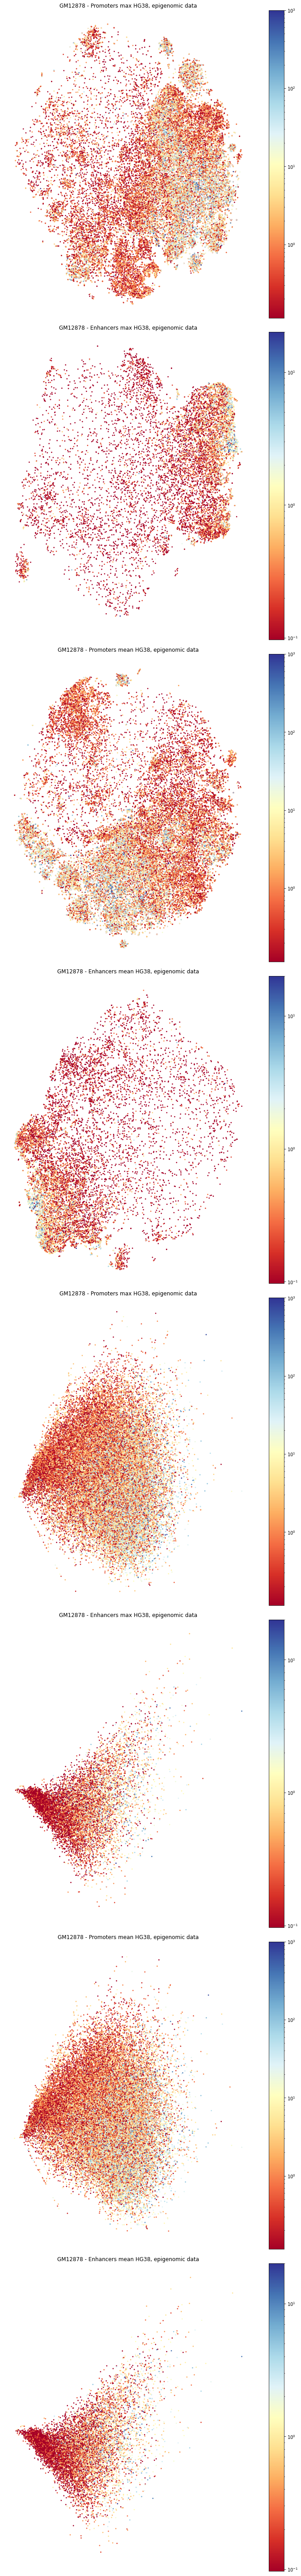

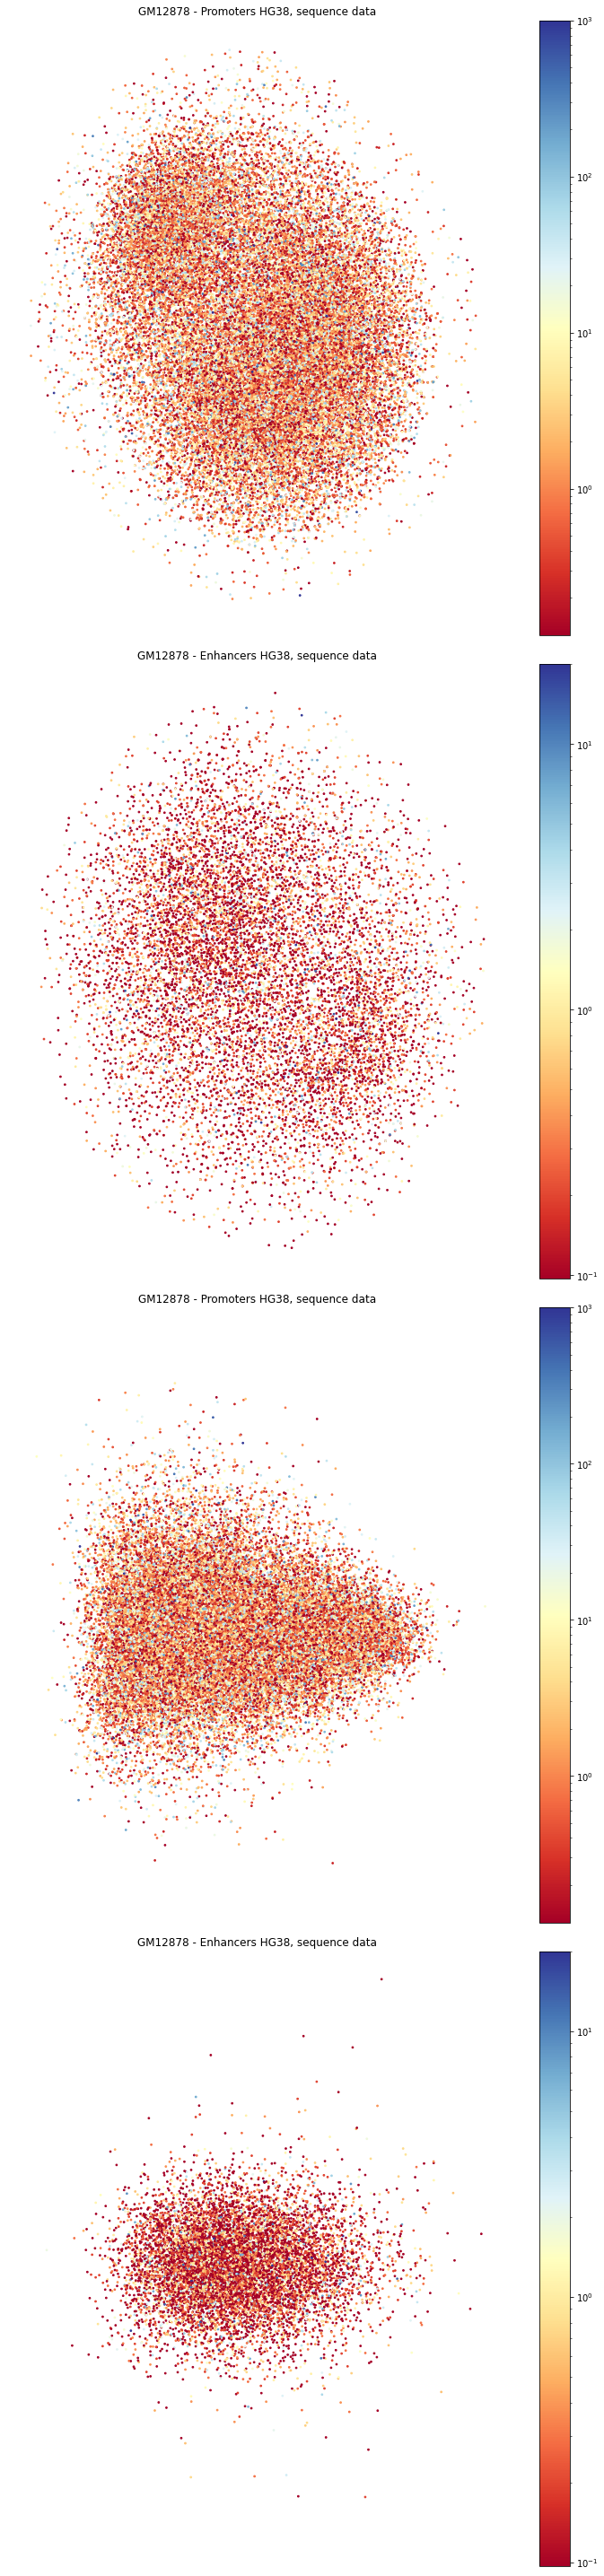

In [7]:
epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=8,
    ncols=1,
    figsize=(10, 80),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(10, 40),
    squeeze=False
)

for k, metric in enumerate(tqdm(("max", "mean"), desc="Metrics", leave=False)):
    for l, decomposition_method in enumerate(tqdm((get_tsne_decomposition, get_pca_decomposition), desc="Decomposition method", leave=False)):
        for j, ((epigenomic, scores), region, clip_value) in enumerate(tqdm((
            (active_promoters_vs_inactive_promoters(cell_line=cell_line, metric=metric), "Promoters", 1000),
            (active_enhancers_vs_inactive_enhancers(cell_line=cell_line,metric=metric), "Enhancers", 20)
        ), desc="Task", leave=False)):
            # imputation and scaling of the data
            imputed_epigenomic = pd.DataFrame(
                MinMaxScaler().fit_transform(
                    KNNImputer().fit_transform(epigenomic)
                ),
                columns=epigenomic.columns,
                index=epigenomic.index
            )
            decomposed_epigenomic = decomposition_method(
                imputed_epigenomic,
                "epigenomic",
                region,
                cell_line,
                metric
            )
            scores[scores>clip_value] = clip_value
            scatter_with_heatmap(
                decomposition=decomposed_epigenomic,
                scores=scores.values,
                figure=epigenomic_fig,
                ax=epigenomic_axes[j + 2*k + l*4][0]
            )
            epigenomic_axes[j + 2*k + l*4][0].set_title(f"{cell_line} - {region} {metric} HG38, epigenomic data")
            epigenomic_axes[j + 2*k + l*4][0].set_axis_off()

            if k==0:
                sequence = pd.DataFrame(
                    np.array(BedSequence(
                        genome,
                        bed=to_bed(scores),
                        batch_size=1
                    )).reshape(-1, 4*256),
                    index=scores.index
                )
                decomposed_sequence = decomposition_method(
                    sequence,
                    "sequence",
                    region,
                    cell_line,
                    metric="None",
                    # It would be better to use the COSINE distance,
                    # but it is too terribly slow to be feaseable
                    # with all the considered use cases.
                    # distance_metric="cosine"
                )
                scatter_with_heatmap(
                    decomposition=decomposed_sequence,
                    scores=scores.values,
                    figure=sequence_fig,
                    ax=sequence_axes[j + l*2][0]
                )
                sequence_axes[j + l*2][0].set_title(f"{cell_line} - {region} HG38, sequence data")
                sequence_axes[j + l*2][0].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()